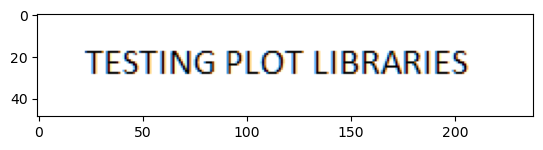

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
image = cv2.imread('C:/datasets/test.png')
plt.imshow(image)
plt.show()

In [2]:
import time
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

In [3]:
PATH = "C:/datasets/digit-recognizer/"

torch.manual_seed(2020)
np.random.seed(2020)
random.seed(2020)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    torch.cuda.get_device_name()

In [4]:
embedding_dims = 2
batch_size = 32
epochs = 100

In [5]:
train_df = pd.read_csv(PATH+"train.csv")
test_df = pd.read_csv(PATH+"test.csv")

train_df = train_df.loc[:4000]; train_df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3996,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3997,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3999,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Define class MNIST
I'll define `class MNIST` which was inherited `torch.utils.data.Dataset`.

In [6]:
class MNIST(Dataset):
    def __init__(self, df, train=True, transform=None):
        self.is_train = train
        self.transform = transform
        self.to_pil = transforms.ToPILImage()
        
        if self.is_train:            
            self.images = df.iloc[:, 1:].values.astype(np.uint8)
            self.labels = df.iloc[:, 0].values
            self.index = df.index.values
        else:
            self.images = df.values.astype(np.uint8)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, item):
        anchor_img = self.images[item].reshape(28, 28, 1)
        
        if self.is_train:
            anchor_label = self.labels[item]

            positive_list = self.index[self.index!=item][self.labels[self.index!=item]==anchor_label]

            positive_item = random.choice(positive_list)
            positive_img = self.images[positive_item].reshape(28, 28, 1)
            
            negative_list = self.index[self.index!=item][self.labels[self.index!=item]!=anchor_label]
            negative_item = random.choice(negative_list)
            negative_img = self.images[negative_item].reshape(28, 28, 1)
            
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
                positive_img = self.transform(self.to_pil(positive_img))
                negative_img = self.transform(self.to_pil(negative_img))
            
            return anchor_img, positive_img, negative_img, anchor_label
        
        else:
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
            return anchor_img
        

In [7]:
train_ds = MNIST(train_df, 
                 train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)

In [8]:
test_ds = MNIST(test_df, train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

In [9]:
anchor_img, positive_img, negative_img, anchor_label = train_ds.__getitem__(0)

In [10]:
anchor_label

1

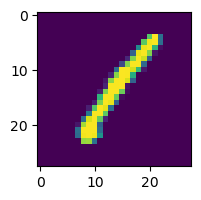

anchor_img


In [11]:
plt.figure(figsize=(2, 2))
plt.imshow(anchor_img.view(28,28), interpolation='nearest')
plt.show() 
print('anchor_img')

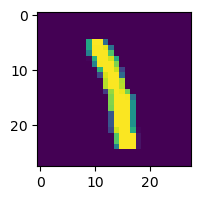

positive_img


In [12]:
plt.figure(figsize=(2, 2))
plt.imshow(positive_img.view(28,28), interpolation='nearest')
plt.show() 
print('positive_img')

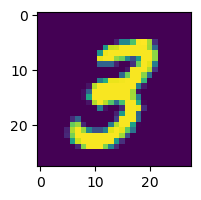

negative_img


In [13]:
plt.figure(figsize=(2, 2))
plt.imshow(negative_img.view(28,28), interpolation='nearest')
plt.show() 
print('negative_img')

## Define TripletLoss

In [14]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

## Define Neural Network

In [15]:
class Network(nn.Module):
    def __init__(self, emb_dim=128):
        super(Network, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, 5),
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(64*4*4, 512),
            nn.PReLU(),
            nn.Linear(512, emb_dim)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64*4*4)
        x = self.fc(x)
#         x = nn.functional.normalize(x)
        return x

### weight initialize

In [16]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight)

### Create Instances
Use JIT compilation for high speed.

In [17]:
model = Network(embedding_dims)
model.apply(init_weights)
model = torch.jit.script(model).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.00001)
criterion = torch.jit.script(TripletLoss())

## Training Loop

In [22]:
# epochs = 30

In [23]:
model.train()
overall_loss_min = 0.010772
for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = []
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)
        
        optimizer.zero_grad()
        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.cpu().detach().numpy())
        
    overall_loss = np.mean(running_loss)
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, overall_loss))
    if overall_loss <= overall_loss_min:
            print('loss was improved ({:.6f} --> {:.6f}).  Saving model ...'.format(overall_loss_min, overall_loss))
            torch.save(model.state_dict(), 'encoder_image.pt')
            overall_loss_min = overall_loss
            print("=========================================")

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 1/30 - Loss: 0.0099
loss was improved (0.010772 --> 0.009950).  Saving model ...


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 2/30 - Loss: 0.0110


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 3/30 - Loss: 0.0069
loss was improved (0.009950 --> 0.006870).  Saving model ...


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 4/30 - Loss: 0.0134


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 5/30 - Loss: 0.0091


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 6/30 - Loss: 0.0134


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 7/30 - Loss: 0.0085


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 8/30 - Loss: 0.0078


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 9/30 - Loss: 0.0067
loss was improved (0.006870 --> 0.006678).  Saving model ...


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 10/30 - Loss: 0.0077


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 11/30 - Loss: 0.0076


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 12/30 - Loss: 0.0118


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 13/30 - Loss: 0.0053
loss was improved (0.006678 --> 0.005345).  Saving model ...


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 14/30 - Loss: 0.0065


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 15/30 - Loss: 0.0071


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 16/30 - Loss: 0.0104


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 17/30 - Loss: 0.0084


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 18/30 - Loss: 0.0096


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 19/30 - Loss: 0.0081


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 20/30 - Loss: 0.0074


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 21/30 - Loss: 0.0083


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 22/30 - Loss: 0.0051
loss was improved (0.005345 --> 0.005107).  Saving model ...


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 23/30 - Loss: 0.0062


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 24/30 - Loss: 0.0070


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 25/30 - Loss: 0.0055


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 26/30 - Loss: 0.0114


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 27/30 - Loss: 0.0085


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 28/30 - Loss: 0.0059


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 29/30 - Loss: 0.0066


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 30/30 - Loss: 0.0080


## Save Params

In [18]:
model.load_state_dict(torch.load('encoder_image.pt'))

<All keys matched successfully>

In [19]:
# torch.save({"model_state_dict": model.state_dict(),
#             "optimzier_state_dict": optimizer.state_dict()
#            }, "trained_model.pth")

In [20]:
train_results = []
labels = []

model.eval()
with torch.no_grad():
    for img, _, _, label in tqdm(train_loader):
        train_results.append(model(img.to(device)).cpu().numpy())
        labels.append(label)
        
train_results = np.concatenate(train_results)
labels = np.concatenate(labels)
train_results.shape

  0%|          | 0/126 [00:00<?, ?it/s]

(4001, 2)

## Visualization 

In [21]:
from torch.nn import CosineSimilarity

def cosine_sim(x,y):
    x, y = torch.tensor(x), torch.tensor(y)
    cos = CosineSimilarity(dim=1, eps=1e-6)
    coef_of_similarity = cos(x.view(1,-1).float(), y.view(1,-1).float())
    return coef_of_similarity

In [22]:
number = 7

In [23]:
listof = np.where(labels == number)[0][:300]
for i in range(listof.shape[0]):
    if i == 299:
        break
    print(f'cos sim between {labels[listof[i]]} and {labels[listof[i]]} is {cosine_sim(train_results[listof[i]], train_results[listof[i+1]])}')

cos sim between 7 and 7 is tensor([0.9931])
cos sim between 7 and 7 is tensor([0.9983])
cos sim between 7 and 7 is tensor([0.9858])
cos sim between 7 and 7 is tensor([0.9943])
cos sim between 7 and 7 is tensor([0.9932])
cos sim between 7 and 7 is tensor([0.9990])
cos sim between 7 and 7 is tensor([0.9785])
cos sim between 7 and 7 is tensor([0.9901])
cos sim between 7 and 7 is tensor([0.9883])
cos sim between 7 and 7 is tensor([0.9695])
cos sim between 7 and 7 is tensor([0.9995])
cos sim between 7 and 7 is tensor([0.9994])
cos sim between 7 and 7 is tensor([0.9830])
cos sim between 7 and 7 is tensor([1.0000])
cos sim between 7 and 7 is tensor([0.9825])
cos sim between 7 and 7 is tensor([0.9818])
cos sim between 7 and 7 is tensor([0.9755])
cos sim between 7 and 7 is tensor([0.9858])
cos sim between 7 and 7 is tensor([0.9950])
cos sim between 7 and 7 is tensor([0.9986])
cos sim between 7 and 7 is tensor([0.9999])
cos sim between 7 and 7 is tensor([0.9859])
cos sim between 7 and 7 is tenso

In [24]:
listofnot = np.where(labels != number)[0][:300]
for i in range(listof.shape[0]):
    if i == 299:
        break
    print(f'cos sim between {labels[listof[i]]} and {labels[listofnot[i]]} is {cosine_sim(train_results[listof[i]], train_results[listofnot[i]])}')

cos sim between 7 and 3 is tensor([-0.4924])
cos sim between 7 and 9 is tensor([0.5402])
cos sim between 7 and 6 is tensor([-0.3367])
cos sim between 7 and 1 is tensor([0.8663])
cos sim between 7 and 9 is tensor([0.2679])
cos sim between 7 and 2 is tensor([0.3114])
cos sim between 7 and 3 is tensor([-0.4357])
cos sim between 7 and 6 is tensor([-0.3315])
cos sim between 7 and 6 is tensor([-0.4291])
cos sim between 7 and 2 is tensor([0.3982])
cos sim between 7 and 2 is tensor([0.3021])
cos sim between 7 and 2 is tensor([0.3874])
cos sim between 7 and 0 is tensor([-0.9172])
cos sim between 7 and 8 is tensor([-0.9808])
cos sim between 7 and 4 is tensor([0.5511])
cos sim between 7 and 2 is tensor([0.6304])
cos sim between 7 and 9 is tensor([0.7512])
cos sim between 7 and 8 is tensor([-0.9059])
cos sim between 7 and 8 is tensor([-0.9772])
cos sim between 7 and 2 is tensor([0.3366])
cos sim between 7 and 3 is tensor([-0.3732])
cos sim between 7 and 3 is tensor([-0.3186])
cos sim between 7 and

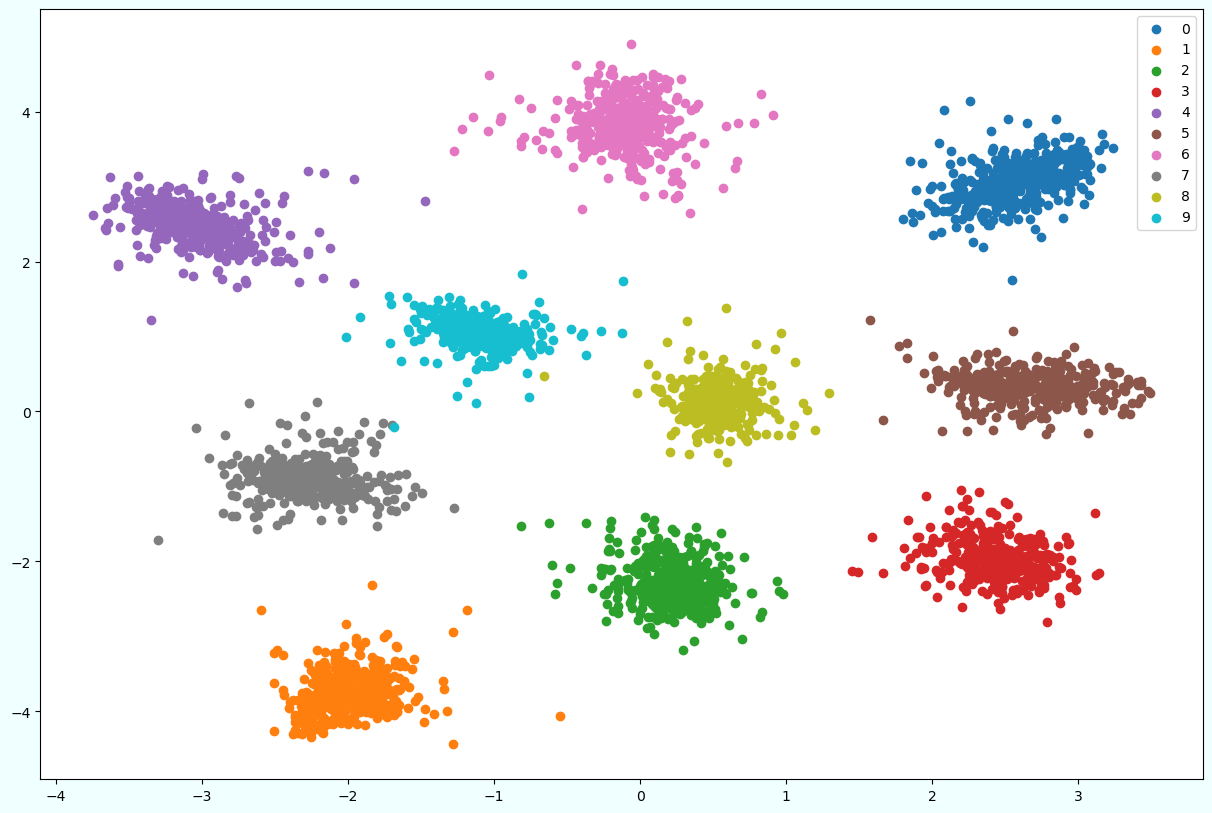

In [25]:
plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(labels):
    tmp = train_results[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)

plt.legend()
plt.show()